In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, RocCurveDisplay, classification_report

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.config.run_functions_eagerly(True)

### Loading data

In [6]:
df_prompts = pd.read_csv('data/train_prompts.csv')
df_train = pd.read_csv('data/train_essays.csv')
df_excerpts = pd.read_csv('data/excerpts.csv')

In [4]:
df_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [7]:
df_excerpts

,excerpt_id,excerpt_prompt,excerp_title,excerpt
0,0,cars,"In German Suburb, Life Goes On Without Cars by...","VAUBAN, Germany-Residents of this upscale comm..."
1,1,cars,Paris bans driving due to smog by Robert Duffer,"After days of near-record pollution, Paris enf..."
2,2,cars,Car-free day is spinning into a big hit in Bog...,"BOGOTA, Colombia-In a program that's set to sp..."
3,3,cars,The End of Car Culture by Elisabeth Rosenthal,President Obama's ambitious goals to curb the ...
4,4,electoral,What Is the Electoral College? by the Office o...,"The Electoral College is a process, not a plac..."
5,5,electoral,The Indefensible Electoral College: Why even t...,"What have Richard Nixon, Jimmy Carter, Bob Dol..."
6,6,electoral,In Defense of the Electoral College: Five reas...,The Electoral College is widely regarded as an...


In [17]:
df_train

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


### Copying training set and adding text length parameter

In [18]:
df_train_an = df_train.copy()

In [19]:
df_train_an.drop(['id', 'prompt_id'], axis=1, inplace=True)
df_train_an['text_len'] = [len(text) for text in df_train_an['text']]

In [20]:
df_train_an

,text,generated,text_len
0,Cars. Cars have been around since they became ...,0,3289
1,Transportation is a large necessity in most co...,0,2738
2,"""America's love affair with it's vehicles seem...",0,4428
3,How often do you ride in a car? Do you drive a...,0,4013
4,Cars are a wonderful thing. They are perhaps o...,0,4698
...,...,...,...
1373,There has been a fuss about the Elector Colleg...,0,2406
1374,Limiting car usage has many advantages. Such a...,0,2073
1375,There's a new trend that has been developing f...,0,4339
1376,As we all know cars are a big part of our soci...,0,2810


In [21]:
df_train_an['text_len'].describe()

count    1378.000000
mean     3169.050798
std       920.588198
min      1356.000000
25%      2554.250000
50%      2985.500000
75%      3623.750000
max      8436.000000
Name: text_len, dtype: float64

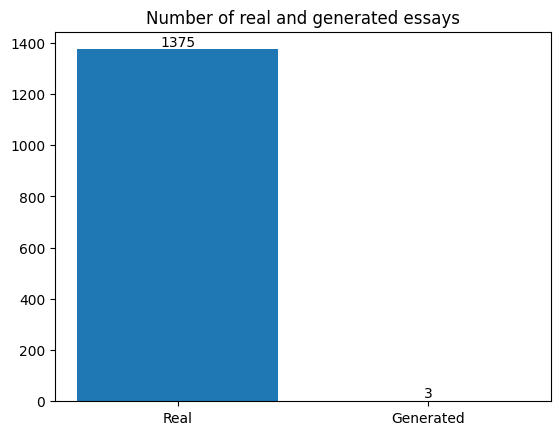

In [23]:
class_counts = df_train_an.generated.value_counts().values
class_names = df_train_an.generated.unique()
tick = ['Real','Generated']

fig, ax = plt.subplots()
bars = ax.bar(class_names, class_counts, tick_label=tick)
ax.bar_label(bars)
plt.title('Number of real and generated essays');

### Realizing the dataset is imbalanced a new source of training material was found. 
Please see README for source, Note this dataset is to big to be uploaded to a remote.

In [25]:
training1 = pd.read_csv('../DATA/LLM_data/train_drcat_01.csv')
training2 = pd.read_csv('../DATA/LLM_data/train_drcat_02.csv')
training3 = pd.read_csv('../DATA/LLM_data/train_drcat_03.csv')
training4 = pd.read_csv('../DATA/LLM_data/train_drcat_04.csv')

df_training = pd.concat([training1,training2, training3, training4], ignore_index=True)
df_training['length'] = [len(text) for text in df_training['text']]
df_training

,text,label,source,fold,essay_id,prompt,length
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2,NaN,NaN,2093
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4,NaN,NaN,2296
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0,NaN,NaN,1654
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0,NaN,NaN,2638
4,My argument for the development of the driverl...,0,persuade_corpus,3,NaN,NaN,1834
...,...,...,...,...,...,...,...
159451,"""Oh man I didn't make the soccer team!"", yelle...",0,persuade_corpus,7,F7341069C4A4,NaN,2299
159452,I believe that using this technology could be ...,0,persuade_corpus,8,AFE6E553DAC2,NaN,1887
159453,The Face on Mars is a fascinating phenomenon t...,1,falcon_180b_v1,3,falcon_180b_v1_600,You have read the article 'Unmasking the Face ...,1856
159454,Texting & Driving\n\nUsing your phone while dr...,0,persuade_corpus,1,A5F84C104693,NaN,2053


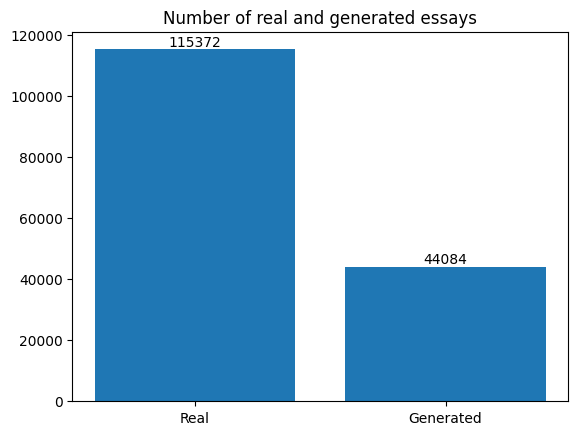

In [27]:
class_counts = df_training.label.value_counts().values
class_names = df_training.label.unique()
tick = ['Real','Generated']

fig, ax = plt.subplots()
bars = ax.bar(class_names, class_counts, tick_label=tick)
ax.bar_label(bars)
plt.title('Number of real and generated essays');

### Splitting data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_training['text'], df_training['label'])

### Creating a model

In [29]:
hub_layer = hub.KerasLayer("https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/en-dim128/versions/1",
                           input_shape=[], dtype=tf.string)

model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124644769 (475.48 MB)
Trainable params: 2081 (8.13 KB)
Non-trainable params: 124642688 (475.47 MB)
_________________________________________________________________


In [30]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics='accuracy'
)

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='output/best_model', save_best_only=True, )

callbacks = [early_stopping, checkpoint]

### Fitting the model

In [32]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


c:\Users\48795\anaconda3\envs\Python3115-tensorflow\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


935/935 [==============================] - ETA: 0s - loss: 0.4267 - accuracy: 0.8017INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 196s 210ms/step - loss: 0.4267 - accuracy: 0.8017 - val_loss: 0.2970 - val_accuracy: 0.8939
Epoch 2/100
935/935 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9167INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 166s 178ms/step - loss: 0.2416 - accuracy: 0.9167 - val_loss: 0.2026 - val_accuracy: 0.9310
Epoch 3/100
935/935 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9393INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 162s 173ms/step - loss: 0.1807 - accuracy: 0.9393 - val_loss: 0.1647 - val_accuracy: 0.9460
Epoch 4/100
935/935 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9492INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 163s 175ms/step - loss: 0.1527 - accuracy: 0.9492 - val_loss: 0.1447 - val_accuracy: 0.9532
Epoch 5/100
935/935 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9547INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 164s 175ms/step - loss: 0.1367 - accuracy: 0.9547 - val_loss: 0.1318 - val_accuracy: 0.9565
Epoch 6/100
935/935 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9578INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 164s 175ms/step - loss: 0.1261 - accuracy: 0.9578 - val_loss: 0.1232 - val_accuracy: 0.9598
Epoch 7/100
935/935 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9604INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 163s 175ms/step - loss: 0.1185 - accuracy: 0.9604 - val_loss: 0.1163 - val_accuracy: 0.9618
Epoch 8/100
935/935 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9619INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 161s 172ms/step - loss: 0.1126 - accuracy: 0.9619 - val_loss: 0.1113 - val_accuracy: 0.9636
Epoch 9/100
935/935 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9633INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 168s 180ms/step - loss: 0.1078 - accuracy: 0.9633 - val_loss: 0.1069 - val_accuracy: 0.9646
Epoch 10/100
935/935 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9645INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 175s 188ms/step - loss: 0.1040 - accuracy: 0.9645 - val_loss: 0.1034 - val_accuracy: 0.9660
Epoch 11/100
935/935 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9658INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 180s 193ms/step - loss: 0.1007 - accuracy: 0.9658 - val_loss: 0.1002 - val_accuracy: 0.9670
Epoch 12/100
935/935 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9664INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 182s 195ms/step - loss: 0.0978 - accuracy: 0.9664 - val_loss: 0.0979 - val_accuracy: 0.9672
Epoch 13/100
935/935 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9671INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 197s 211ms/step - loss: 0.0953 - accuracy: 0.9671 - val_loss: 0.0954 - val_accuracy: 0.9686
Epoch 14/100
935/935 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9677INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 212s 227ms/step - loss: 0.0931 - accuracy: 0.9677 - val_loss: 0.0934 - val_accuracy: 0.9693
Epoch 15/100
935/935 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.9683INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 223s 239ms/step - loss: 0.0911 - accuracy: 0.9683 - val_loss: 0.0914 - val_accuracy: 0.9694
Epoch 16/100
935/935 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9689INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 217s 233ms/step - loss: 0.0894 - accuracy: 0.9689 - val_loss: 0.0900 - val_accuracy: 0.9699
Epoch 17/100
935/935 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9694INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 218s 233ms/step - loss: 0.0878 - accuracy: 0.9694 - val_loss: 0.0884 - val_accuracy: 0.9706
Epoch 18/100
935/935 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9700INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 223s 238ms/step - loss: 0.0864 - accuracy: 0.9700 - val_loss: 0.0870 - val_accuracy: 0.9708
Epoch 19/100
935/935 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9705INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 210s 225ms/step - loss: 0.0851 - accuracy: 0.9705 - val_loss: 0.0859 - val_accuracy: 0.9708
Epoch 20/100
935/935 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9710INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 216s 231ms/step - loss: 0.0839 - accuracy: 0.9710 - val_loss: 0.0846 - val_accuracy: 0.9714
Epoch 21/100
935/935 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9712INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 242s 259ms/step - loss: 0.0828 - accuracy: 0.9712 - val_loss: 0.0837 - val_accuracy: 0.9719
Epoch 22/100
935/935 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9716INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 235s 251ms/step - loss: 0.0818 - accuracy: 0.9716 - val_loss: 0.0827 - val_accuracy: 0.9726
Epoch 23/100
935/935 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9720INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 249s 266ms/step - loss: 0.0809 - accuracy: 0.9720 - val_loss: 0.0822 - val_accuracy: 0.9724
Epoch 24/100
935/935 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9725INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 208s 223ms/step - loss: 0.0800 - accuracy: 0.9725 - val_loss: 0.0810 - val_accuracy: 0.9732
Epoch 25/100
935/935 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9725INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 222s 238ms/step - loss: 0.0791 - accuracy: 0.9725 - val_loss: 0.0803 - val_accuracy: 0.9735
Epoch 26/100
935/935 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9729INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 228s 244ms/step - loss: 0.0784 - accuracy: 0.9729 - val_loss: 0.0796 - val_accuracy: 0.9737
Epoch 27/100
935/935 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9732INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 252s 270ms/step - loss: 0.0777 - accuracy: 0.9732 - val_loss: 0.0790 - val_accuracy: 0.9739
Epoch 28/100
935/935 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9734INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 234s 250ms/step - loss: 0.0770 - accuracy: 0.9734 - val_loss: 0.0783 - val_accuracy: 0.9745
Epoch 29/100
935/935 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9738INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 250s 267ms/step - loss: 0.0763 - accuracy: 0.9738 - val_loss: 0.0776 - val_accuracy: 0.9746
Epoch 30/100
935/935 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9739INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 226s 242ms/step - loss: 0.0758 - accuracy: 0.9739 - val_loss: 0.0771 - val_accuracy: 0.9747
Epoch 31/100
935/935 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9744INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 223s 239ms/step - loss: 0.0751 - accuracy: 0.9744 - val_loss: 0.0765 - val_accuracy: 0.9747
Epoch 32/100
935/935 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9745INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 254s 272ms/step - loss: 0.0746 - accuracy: 0.9745 - val_loss: 0.0762 - val_accuracy: 0.9749
Epoch 33/100
935/935 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9747INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 247s 265ms/step - loss: 0.0740 - accuracy: 0.9747 - val_loss: 0.0755 - val_accuracy: 0.9753
Epoch 34/100
935/935 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9750INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 244s 261ms/step - loss: 0.0735 - accuracy: 0.9750 - val_loss: 0.0752 - val_accuracy: 0.9754
Epoch 35/100
935/935 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9752INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 235s 252ms/step - loss: 0.0730 - accuracy: 0.9752 - val_loss: 0.0746 - val_accuracy: 0.9753
Epoch 36/100
935/935 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9754INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 268s 287ms/step - loss: 0.0725 - accuracy: 0.9754 - val_loss: 0.0740 - val_accuracy: 0.9757
Epoch 37/100
935/935 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9757INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 255s 273ms/step - loss: 0.0720 - accuracy: 0.9757 - val_loss: 0.0736 - val_accuracy: 0.9756
Epoch 38/100
935/935 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9758INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 245s 263ms/step - loss: 0.0715 - accuracy: 0.9758 - val_loss: 0.0733 - val_accuracy: 0.9758
Epoch 39/100
935/935 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9760INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 230s 246ms/step - loss: 0.0710 - accuracy: 0.9760 - val_loss: 0.0728 - val_accuracy: 0.9757
Epoch 40/100
935/935 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9761INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 217s 232ms/step - loss: 0.0706 - accuracy: 0.9761 - val_loss: 0.0722 - val_accuracy: 0.9761
Epoch 41/100
935/935 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9765INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 217s 232ms/step - loss: 0.0701 - accuracy: 0.9765 - val_loss: 0.0718 - val_accuracy: 0.9762
Epoch 42/100
935/935 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9765INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 227s 243ms/step - loss: 0.0696 - accuracy: 0.9765 - val_loss: 0.0715 - val_accuracy: 0.9764
Epoch 43/100
935/935 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9765INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 230s 246ms/step - loss: 0.0692 - accuracy: 0.9765 - val_loss: 0.0711 - val_accuracy: 0.9765
Epoch 44/100
935/935 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9769INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 224s 239ms/step - loss: 0.0687 - accuracy: 0.9769 - val_loss: 0.0708 - val_accuracy: 0.9765
Epoch 45/100
935/935 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9771INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 225s 241ms/step - loss: 0.0684 - accuracy: 0.9771 - val_loss: 0.0702 - val_accuracy: 0.9766
Epoch 46/100
935/935 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9771INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 228s 244ms/step - loss: 0.0679 - accuracy: 0.9771 - val_loss: 0.0700 - val_accuracy: 0.9768
Epoch 47/100
935/935 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9774INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 234s 251ms/step - loss: 0.0675 - accuracy: 0.9774 - val_loss: 0.0695 - val_accuracy: 0.9769
Epoch 48/100
935/935 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9774INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 255s 273ms/step - loss: 0.0671 - accuracy: 0.9774 - val_loss: 0.0692 - val_accuracy: 0.9771
Epoch 49/100
935/935 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9776INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 228s 244ms/step - loss: 0.0668 - accuracy: 0.9776 - val_loss: 0.0688 - val_accuracy: 0.9770
Epoch 50/100
935/935 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9777INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 224s 239ms/step - loss: 0.0664 - accuracy: 0.9777 - val_loss: 0.0686 - val_accuracy: 0.9772
Epoch 51/100
935/935 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9780INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 227s 243ms/step - loss: 0.0660 - accuracy: 0.9780 - val_loss: 0.0681 - val_accuracy: 0.9771
Epoch 52/100
935/935 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9781INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 247s 264ms/step - loss: 0.0656 - accuracy: 0.9781 - val_loss: 0.0678 - val_accuracy: 0.9773
Epoch 53/100
935/935 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9781INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 254s 272ms/step - loss: 0.0653 - accuracy: 0.9781 - val_loss: 0.0674 - val_accuracy: 0.9773
Epoch 54/100
935/935 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9781INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 246s 263ms/step - loss: 0.0649 - accuracy: 0.9781 - val_loss: 0.0671 - val_accuracy: 0.9777
Epoch 55/100
935/935 [==============================] - 234s 251ms/step - loss: 0.0646 - accuracy: 0.9784 - val_loss: 0.0675 - val_accuracy: 0.9783
Epoch 56/100
935/935 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9785INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 273s 292ms/step - loss: 0.0642 - accuracy: 0.9785 - val_loss: 0.0665 - val_accuracy: 0.9780
Epoch 57/100
935/935 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9786INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 256s 274ms/step - loss: 0.0639 - accuracy: 0.9786 - val_loss: 0.0661 - val_accuracy: 0.9781
Epoch 58/100
935/935 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9788INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 244s 261ms/step - loss: 0.0636 - accuracy: 0.9788 - val_loss: 0.0659 - val_accuracy: 0.9785
Epoch 59/100
935/935 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9787INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 260s 278ms/step - loss: 0.0633 - accuracy: 0.9787 - val_loss: 0.0656 - val_accuracy: 0.9780
Epoch 60/100
935/935 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9789INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 254s 272ms/step - loss: 0.0629 - accuracy: 0.9789 - val_loss: 0.0652 - val_accuracy: 0.9784
Epoch 61/100
935/935 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.9790INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 253s 271ms/step - loss: 0.0625 - accuracy: 0.9790 - val_loss: 0.0649 - val_accuracy: 0.9786
Epoch 62/100
935/935 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9790INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 248s 265ms/step - loss: 0.0622 - accuracy: 0.9790 - val_loss: 0.0647 - val_accuracy: 0.9781
Epoch 63/100
935/935 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9792INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 235s 251ms/step - loss: 0.0619 - accuracy: 0.9792 - val_loss: 0.0646 - val_accuracy: 0.9790
Epoch 64/100
935/935 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9793INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 268s 287ms/step - loss: 0.0616 - accuracy: 0.9793 - val_loss: 0.0640 - val_accuracy: 0.9788
Epoch 65/100
935/935 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9792INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 244s 261ms/step - loss: 0.0613 - accuracy: 0.9792 - val_loss: 0.0637 - val_accuracy: 0.9788
Epoch 66/100
935/935 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9795INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 226s 242ms/step - loss: 0.0610 - accuracy: 0.9795 - val_loss: 0.0636 - val_accuracy: 0.9790
Epoch 67/100
935/935 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9796INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 224s 240ms/step - loss: 0.0607 - accuracy: 0.9796 - val_loss: 0.0632 - val_accuracy: 0.9793
Epoch 68/100
935/935 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9797INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 190s 203ms/step - loss: 0.0604 - accuracy: 0.9797 - val_loss: 0.0630 - val_accuracy: 0.9795
Epoch 69/100
935/935 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9798INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 221s 237ms/step - loss: 0.0600 - accuracy: 0.9798 - val_loss: 0.0626 - val_accuracy: 0.9793
Epoch 70/100
935/935 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9799INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 208s 223ms/step - loss: 0.0598 - accuracy: 0.9799 - val_loss: 0.0625 - val_accuracy: 0.9796
Epoch 71/100
935/935 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9799INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 213s 228ms/step - loss: 0.0595 - accuracy: 0.9799 - val_loss: 0.0622 - val_accuracy: 0.9796
Epoch 72/100
935/935 [==============================] - 212s 227ms/step - loss: 0.0592 - accuracy: 0.9801 - val_loss: 0.0623 - val_accuracy: 0.9798
Epoch 73/100
935/935 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9802INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 238s 254ms/step - loss: 0.0590 - accuracy: 0.9802 - val_loss: 0.0619 - val_accuracy: 0.9799
Epoch 74/100
935/935 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9804INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 253s 270ms/step - loss: 0.0587 - accuracy: 0.9804 - val_loss: 0.0618 - val_accuracy: 0.9799
Epoch 75/100
935/935 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9803INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 194s 208ms/step - loss: 0.0584 - accuracy: 0.9803 - val_loss: 0.0611 - val_accuracy: 0.9801
Epoch 76/100
935/935 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9803INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 218s 233ms/step - loss: 0.0582 - accuracy: 0.9803 - val_loss: 0.0608 - val_accuracy: 0.9801
Epoch 77/100
935/935 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9806INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 218s 233ms/step - loss: 0.0579 - accuracy: 0.9806 - val_loss: 0.0606 - val_accuracy: 0.9805
Epoch 78/100
935/935 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9807INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 218s 234ms/step - loss: 0.0576 - accuracy: 0.9807 - val_loss: 0.0603 - val_accuracy: 0.9806
Epoch 79/100
935/935 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9809INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 219s 235ms/step - loss: 0.0573 - accuracy: 0.9809 - val_loss: 0.0602 - val_accuracy: 0.9799
Epoch 80/100
935/935 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9807INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 215s 230ms/step - loss: 0.0571 - accuracy: 0.9807 - val_loss: 0.0599 - val_accuracy: 0.9805
Epoch 81/100
935/935 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9810INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 205s 220ms/step - loss: 0.0568 - accuracy: 0.9810 - val_loss: 0.0595 - val_accuracy: 0.9808
Epoch 82/100
935/935 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9811INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 216s 232ms/step - loss: 0.0566 - accuracy: 0.9811 - val_loss: 0.0593 - val_accuracy: 0.9810
Epoch 83/100
935/935 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9812INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 217s 232ms/step - loss: 0.0564 - accuracy: 0.9812 - val_loss: 0.0593 - val_accuracy: 0.9811
Epoch 84/100
935/935 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9815INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 215s 230ms/step - loss: 0.0561 - accuracy: 0.9815 - val_loss: 0.0588 - val_accuracy: 0.9810
Epoch 85/100
935/935 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9812INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 212s 227ms/step - loss: 0.0559 - accuracy: 0.9812 - val_loss: 0.0587 - val_accuracy: 0.9811
Epoch 86/100
935/935 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9815INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 215s 230ms/step - loss: 0.0556 - accuracy: 0.9815 - val_loss: 0.0585 - val_accuracy: 0.9808
Epoch 87/100
935/935 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9815INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 215s 230ms/step - loss: 0.0554 - accuracy: 0.9815 - val_loss: 0.0582 - val_accuracy: 0.9814
Epoch 88/100
935/935 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9815INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 211s 226ms/step - loss: 0.0552 - accuracy: 0.9815 - val_loss: 0.0580 - val_accuracy: 0.9812
Epoch 89/100
935/935 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9817INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 186s 199ms/step - loss: 0.0550 - accuracy: 0.9817 - val_loss: 0.0579 - val_accuracy: 0.9807
Epoch 90/100
935/935 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9817INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 217s 233ms/step - loss: 0.0547 - accuracy: 0.9817 - val_loss: 0.0576 - val_accuracy: 0.9814
Epoch 91/100
935/935 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9818INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 198s 211ms/step - loss: 0.0545 - accuracy: 0.9818 - val_loss: 0.0573 - val_accuracy: 0.9814
Epoch 92/100
935/935 [==============================] - 212s 227ms/step - loss: 0.0543 - accuracy: 0.9818 - val_loss: 0.0573 - val_accuracy: 0.9811
Epoch 93/100
935/935 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9820INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 215s 230ms/step - loss: 0.0541 - accuracy: 0.9820 - val_loss: 0.0571 - val_accuracy: 0.9817
Epoch 94/100
935/935 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9820INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 217s 232ms/step - loss: 0.0539 - accuracy: 0.9820 - val_loss: 0.0568 - val_accuracy: 0.9814
Epoch 95/100
935/935 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9822INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 217s 232ms/step - loss: 0.0537 - accuracy: 0.9822 - val_loss: 0.0566 - val_accuracy: 0.9817
Epoch 96/100
935/935 [==============================] - 220s 235ms/step - loss: 0.0535 - accuracy: 0.9821 - val_loss: 0.0570 - val_accuracy: 0.9814
Epoch 97/100
935/935 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9821INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 221s 237ms/step - loss: 0.0533 - accuracy: 0.9821 - val_loss: 0.0562 - val_accuracy: 0.9816
Epoch 98/100
935/935 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9822INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 215s 230ms/step - loss: 0.0531 - accuracy: 0.9822 - val_loss: 0.0561 - val_accuracy: 0.9817
Epoch 99/100
935/935 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9823INFO:tensorflow:Assets written to: output\best_model\assets


INFO:tensorflow:Assets written to: output\best_model\assets


935/935 [==============================] - 217s 232ms/step - loss: 0.0530 - accuracy: 0.9823 - val_loss: 0.0559 - val_accuracy: 0.9818
Epoch 100/100
935/935 [==============================] - 217s 232ms/step - loss: 0.0527 - accuracy: 0.9823 - val_loss: 0.0559 - val_accuracy: 0.9819


### Loading best model from file and forming predictions

In [33]:
model = tf.keras.models.load_model('output/best_model')

In [34]:
y_pred = model.predict(X_test)

  20/1246 [..............................] - ETA: 6s

c:\Users\48795\anaconda3\envs\Python3115-tensorflow\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1246/1246 [==============================] - 6s 5ms/step


### Displaying ROC Curve, history of learning and Classification report

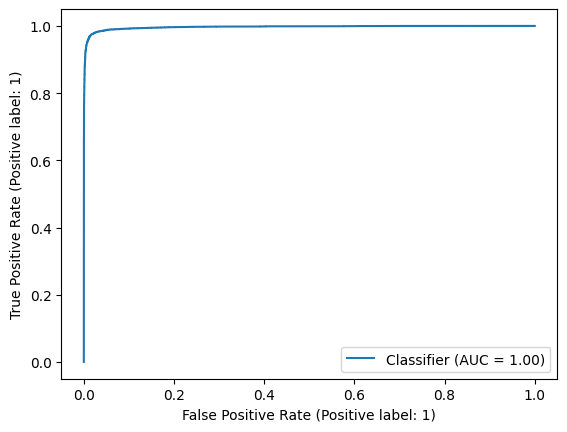

In [35]:
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr).from_predictions(y_test, y_pred);

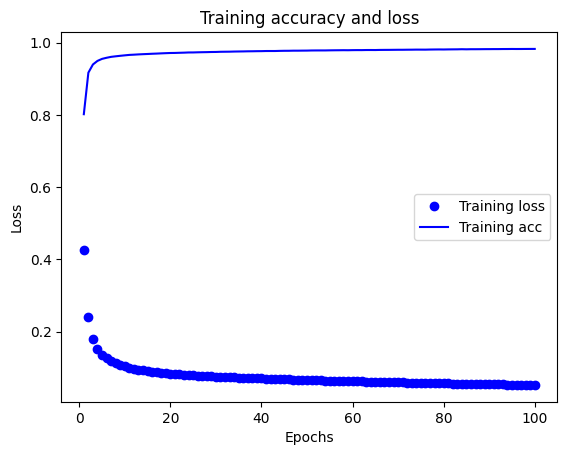

In [36]:
history_dict = history.history

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, acc, 'b', label='Training acc')

plt.title('Training accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
print(classification_report(y_test, y_pred > 0.1))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     28980
           1       0.88      0.99      0.93     10884

    accuracy                           0.96     39864
   macro avg       0.94      0.97      0.95     39864
weighted avg       0.96      0.96      0.96     39864



### Saving prediction to submission.csv as required

In [37]:
df_test = pd.read_csv('data/test_essays.csv')
prediction = model.predict(df_test['text'])
output = pd.DataFrame({'id': df_test.id, 'generated': prediction[:,0]})
output.to_csv('output/submission.csv', index=False)

1/1 [==============================] - 0s 20ms/step


c:\Users\48795\anaconda3\envs\Python3115-tensorflow\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
